This notebook shows how to setup a new project, train a keypoint-MoSeq model and visualize the resulting syllables.

**Total run time: ~90 min.**

# Colab setup

- Make a copy of this notebook if you plan to make changes and want them saved.
- Go to "Runtime">"change runtime type" and select "Python 3" and "GPU"

### Install keypoint MoSeq

In [2]:
! pip install -U keypoint-moseq
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Option 1: Use our example dataset

In [3]:
import gdown
url = 'https://drive.google.com/uc?id=1JGyS9MbdS3MtrlYnh4xdEQwe2bYoCuSZ'
output = 'dlc_example_project.zip'
gdown.download(url, output, quiet=False)
! unzip dlc_example_project.zip

data_dir = "dlc_example_project"

Downloading...
From (original): https://drive.google.com/uc?id=1JGyS9MbdS3MtrlYnh4xdEQwe2bYoCuSZ
From (redirected): https://drive.google.com/uc?id=1JGyS9MbdS3MtrlYnh4xdEQwe2bYoCuSZ&confirm=t&uuid=2c94a82d-37f6-4bb9-928c-7a1f9e682be4
To: /content/dlc_example_project.zip
100%|██████████| 302M/302M [00:01<00:00, 211MB/s]


Archive:  dlc_example_project.zip
   creating: dlc_example_project/
  inflating: dlc_example_project/config.yaml  
   creating: dlc_example_project/videos/
  inflating: dlc_example_project/videos/21_12_10_def6a_3.top.ir.mp4  
  inflating: dlc_example_project/videos/22_04_26_cage4_1_1.top.ir.mp4  
  inflating: dlc_example_project/videos/21_12_10_def6b_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000.h5  
  inflating: dlc_example_project/videos/21_12_2_def6a_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000.h5  
  inflating: dlc_example_project/videos/21_12_10_def6a_1_1.top.ir.mp4  
  inflating: dlc_example_project/videos/21_12_10_def6a_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000.h5  
  inflating: dlc_example_project/videos/22_27_04_cage4_mouse2_0.top.ir.mp4  
  inflating: dlc_example_project/videos/22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000.h5  
  inflating: dlc_example_project/videos/22_04_26_cage4_0.top.ir.mp4  
  inflating: dlc_examp

### Option 2: Use your own data
Upload your data to google drive and then change the following path as needed

In [ ]:
# data_dir = "/content/drive/MyDrive/MY_DATA_DIRECTORY"

# Project setup
Create a new project directory with a keypoint-MoSeq `config.yml` file.

In [4]:
import keypoint_moseq as kpms

project_dir = '/content/drive/MyDrive/demo_project/'
config = lambda: kpms.load_config(project_dir)

### Option 1: Setup from DeepLabCut

In [6]:
dlc_config = os.path.join(data_dir, 'config.yaml')
kpms.setup_project(project_dir, deeplabcut_config=dlc_config)

The directory `/content/drive/MyDrive/demo_project/` already exists.
Use `overwrite=True` or pick a different name


### Option 2: Setup from SLEAP

In [ ]:
# choose a .h5 file for one of your recordings
# sleap_file = os.path.join(data_dir, 'SLEAP_FILE_NAME')
# kpms.setup_project(project_dir, sleap_file=sleap_file)

### Options 3: Manual setup

In [ ]:
# bodyparts=[
#     'tail', 'spine4', 'spine3', 'spine2', 'spine1',
#     'head', 'nose', 'right ear', 'left ear']

# skeleton=[
#     ['tail', 'spine4'],
#     ['spine4', 'spine3'],
#     ['spine3', 'spine2'],
#     ['spine2', 'spine1'],
#     ['spine1', 'head'],
#     ['nose', 'head'],
#     ['left ear', 'head'],
#     ['right ear', 'head']]

# video_dir = os.path.join(data_dir, 'videos')

# kpms.setup_project(
#     project_dir,
#     video_dir=video_dir,
#     bodyparts=bodyparts,
#     skeleton=skeleton)

## Edit the config file

The config can be edited in a text editor or using the function `kpms.update_config`, as shown below. In general, the following parameters should be specified for each project:

- `bodyparts` (name of each keypoint; automatically imported from SLEAP/DeepLabCut)
- `use_bodyparts` (subset of bodyparts to use for modeling, set to all bodyparts by default; for mice we recommend excluding the tail)
- `anterior_bodyparts` and `posterior_bodyparts` (used for rotational alignment)
- `video_dir` (directory with videos of each experiment)

Edit the config as follows for the [example DeepLabCut dataset](https://drive.google.com/drive/folders/1UNHQ_XCQEKLPPSjGspRopWBj6-YNDV6G?usp=share_link):

In [8]:
kpms.update_config(
    project_dir,
    video_dir=os.path.join(data_dir, 'videos'),
    anterior_bodyparts=['nose'],
    posterior_bodyparts=['spine4'],
    use_bodyparts=[
        'spine4', 'spine3', 'spine2', 'spine1',
        'head', 'nose', 'right ear', 'left ear'])

## Load data

The code below shows how to load keypoint detections from DeepLabCut. To load other formats, replace `'deeplabcut'` in the example with one of `'sleap', 'anipose', 'sleap-anipose', 'nwb'`. For other formats, see the [FAQ](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#loading-keypoint-tracking-data).

In [9]:
# load data (e.g. from DeepLabCut)
keypoint_data_path = os.path.join(data_dir, 'videos') # can be a file, a directory, or a list of files
coordinates, confidences, bodyparts = kpms.load_keypoints(keypoint_data_path, 'deeplabcut')

# format data for modeling
data, metadata = kpms.format_data(coordinates, confidences, **config())

Loading keypoints: 100%|████████████████| 10/10 [00:00<00:00, 13.92it/s]


## Calibration [disabled in colab]

The purpose of calibration is to learn the relationship between error and keypoint confidence scores. The resulting regression coefficients (`slope` and `intercept`) are used during modeling to set the noise prior on a per-frame, per-keypoint basis. **This step is disabled in colab**. In any case it can safely be skipped since the default parameters are fine for most datasets.  

## Fit PCA

Run the cell below to fit a PCA model to aligned and centered keypoint coordinates.

- The model is saved to ``{project_dir}/pca.p`` and can be reloaded using ``kpms.load_pca``.
- Two plots are generated: a cumulative [scree plot](https://en.wikipedia.org/wiki/Scree_plot) and a depiction of each PC, where translucent nodes/edges represent the mean pose and opaque nodes/edges represent a perturbation in the direction of the PC.
- After fitting, edit `latent_dimension` in the config. This determines the dimension of the pose trajectory used to fit keypoint-MoSeq. A good heuristic is the number of dimensions needed to explain 90% of variance, or 10 dimensions - whichever is lower.  

>=90.0% of variance exlained by 4 components.


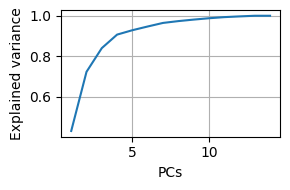

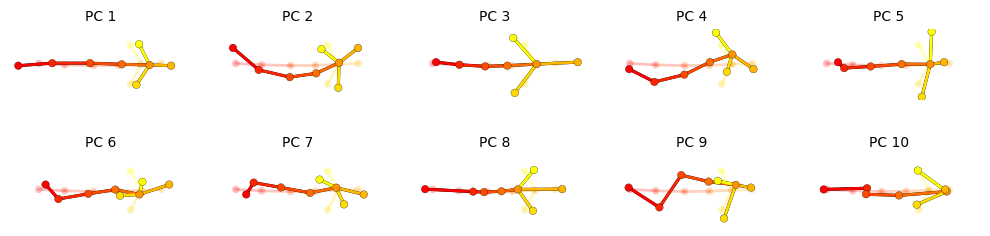

In [10]:
pca = kpms.fit_pca(**data, **config())
kpms.save_pca(pca, project_dir)

kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config())

# use the following to load an already fit model
# pca = kpms.load_pca(project_dir)

In [ ]:
kpms.update_config(project_dir, latent_dim=4)

# Model fitting

Fitting a keypoint-MoSeq model involves:
1. **Initialization:** Auto-regressive (AR) parameters and syllable sequences are randomly initialized using pose trajectories from PCA.
2. **Fitting an AR-HMM:** The AR parameters, transition probabilities and syllable sequences are iteratively updated through Gibbs sampling.
3. **Fitting the full model:** All parameters, including both the AR-HMM as well as centroid, heading, noise-estimates and continuous latent states (i.e. pose trajectories) are iteratively updated through Gibbs sampling. This step is especially useful for noisy data.
4. **Extracting model results:** The learned states of the model are parsed and saved to disk for vizualization and downstream analysis.
4. **[Optional] Applying the trained model:** The learned model parameters can be used to infer a syllable sequences for additional data.

## Setting kappa

Most users will need to adjust the **kappa** hyperparameter to achieve the desired distribution of syllable durations. For this tutorial we chose kappa values that yielded a median syllable duration of 400ms (12 frames). Most users will need to tune kappa to their particular dataset. Higher values of kappa lead to longer syllables. **You will need to pick two kappas: one for AR-HMM fitting and one for the full model.**
- We recommend iteratively updating kappa and refitting the model until the target syllable time-scale is attained.  
- Model fitting can be stopped at any time by interrupting the kernel, and then restarted with a new kappa value.
- The full model will generally require a lower value of kappa to yield the same target syllable durations.
- To adjust the value of kappa in the model, use `kpms.update_hypparams` as shown below. Note that this command only changes kappa in the model dictionary, not the kappa value in the config file. The value in the config is only used during model initialization.

## Initialization

In [11]:
# initialize the model
model = kpms.init_model(data, pca=pca, **config())

# optionally modify kappa
# model = kpms.update_hypparams(model, kappa=NUMBER)

## Fitting an AR-HMM

In addition to fitting an AR-HMM, the function below:
- generates a name for the model and a corresponding directory in `project_dir`
- saves a checkpoint every 25 iterations from which fitting can be restarted
- plots the progress of fitting every 25 iterations, including
    - the distributions of syllable frequencies and durations for the most recent iteration
    - the change in median syllable duration across fitting iterations
    - a sample of the syllable sequence across iterations in a random window

In [ ]:
num_ar_iters = 50

model, model_name = kpms.fit_model(
    model, data, metadata, project_dir,
    ar_only=True, num_iters=num_ar_iters)

Outputs will be saved to
/content/drive/MyDrive/demo_project/2025_02_18-13_01_25


 14%|████▉                               | 7/51 [04:37<28:18, 38.60s/it]

## Fitting the full model

The following code fits a full keypoint-MoSeq model using the results of AR-HMM fitting for initialization. If using your own data, you may need to try a few values of kappa at this step.

In [ ]:
# load model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=num_ar_iters)

# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=1e4)

# run fitting for an additional 500 iters
model = kpms.fit_model(
    model, data, metadata, project_dir, model_name, ar_only=False,
    start_iter=current_iter, num_iters=current_iter+500)[0]


## Sort syllables by frequency

Permute the states and parameters of a saved checkpoint so that syllables are labeled in order of frequency (i.e. so that `0` is the most frequent, `1` is the second most, and so on).

In [ ]:
# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(project_dir, model_name);

```{warning}
Reindexing is only applied to the checkpoint file. Therefore, if you perform this step after extracting the modeling results or generating vizualizations, then those steps must be repeated.
```

## Extract model results

Parse the modeling results and save them to `{project_dir}/{model_name}/results.h5`. The results are stored as follows, and can be reloaded at a later time using `kpms.load_results`. Check the docs for an [in-depth explanation of the modeling results](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#interpreting-model-outputs).
```
    results.h5
    ├──recording_name1
    │  ├──syllable      # syllable labels (z)
    │  ├──latent_state  # inferred low-dim pose state (x)
    │  ├──centroid      # inferred centroid (v)
    │  └──heading       # inferred heading (h)
    ⋮
```

In [ ]:
# load the most recent model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)

# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name)

### [Optional] Save results to csv

After extracting to an h5 file, the results can also be saved as csv files. A separate file will be created for each recording and saved to `{project_dir}/{model_name}/results/`.

In [ ]:
# optionally save results as csv
kpms.save_results_as_csv(results, project_dir, model_name)

## Apply to new data

The code below shows how to apply a trained model to new data. This is useful if you have performed new experiments and would like to maintain an existing set of syllables. The results for the new experiments will be added to the existing `results.h5` file. **This step is optional and can be skipped if you do not have new data to add**.

In [ ]:
# load the most recent model checkpoint and pca object
# model = kpms.load_checkpoint(project_dir, model_name)[0]

# # load new data (e.g. from deeplabcut)
# new_data = 'path/to/new/data/' # can be a file, a directory, or a list of files
# coordinates, confidences, bodyparts = kpms.load_keypoints(new_data, 'deeplabcut')
# data, metadata = kpms.format_data(coordinates, confidences, **config())

# # apply saved model to new data
# results = kpms.apply_model(model, data, metadata, project_dir, model_name, **config())

# optionally rerun `save_results_as_csv` to export the new results
# kpms.save_results_as_csv(results, project_dir, model_name)

# Visualization

## Trajectory plots
Generate plots showing the median trajectory of poses associated with each given syllable.

In [ ]:
results = kpms.load_results(project_dir, model_name)
kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name, **config())

## Grid movies
Generate video clips showing examples of each syllable.

*Note: the code below will only work with 2D data. For 3D data, see the [FAQ](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#making-grid-movies-for-3d-data).*

In [ ]:
kpms.generate_grid_movies(results, project_dir, model_name, coordinates=coordinates, **config());

## Syllable Dendrogram
Plot a dendrogram representing distances between each syllable's median trajectory.

In [ ]:
kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name, **config())